In [2]:
import pandas as pd
import pylab
import sklearn as sk
%pylab inline

df = pd.read_csv('./data/card_transdata.csv')

#separate "fraud" column (class label)
X = df.drop("fraud", axis=1)
y = df["fraud"]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


features = X.columns
results = {}
dt_model = DecisionTreeClassifier(random_state=42)

for feature in features:
    # Drop the feature
    X_ablate = X.drop(feature, axis=1)    
    scores = cross_val_score(dt_model, X_ablate, y, cv=3, scoring='recall_macro', n_jobs=-1)
    results[feature] = np.mean(scores)

print("Ablation study results:")
for k, v in results.items():
    print(f"{k}: recall dropped to {v:.3f}")

Ablation study results:
distance_from_home: recall dropped to 0.888
distance_from_last_transaction: recall dropped to 0.963
ratio_to_median_purchase_price: recall dropped to 0.650
repeat_retailer: recall dropped to 1.000
used_chip: recall dropped to 0.946
used_pin_number: recall dropped to 0.942
online_order: recall dropped to 0.834


In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def add_noise(X, feature, noise_level=0.1):
    # Make a copy of X
    X_noisy = X.copy()
    # Assume you want to add noise to 'ratio_to_median_purchase_price' which has a high correlation to 
    X_noisy[feature] += np.random.normal(0, noise_level, size=X.shape[0])
    return X_noisy

numeric_feature = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

for feature in numeric_feature:
    noise_transformer = FunctionTransformer(add_noise, kw_args={'feature': feature, 'noise_level': 0.2})
    pipeline = make_pipeline(
        noise_transformer,
        dt_model
    )
    scores = cross_val_score(pipeline, X, y, cv=3, scoring='recall_macro', n_jobs=-1)
    print(f"recall after adding noise to '{feature}': {np.mean(scores):.3f}")

recall after adding noise to 'distance_from_home': 1.000
recall after adding noise to 'distance_from_last_transaction': 1.000
recall after adding noise to 'ratio_to_median_purchase_price': 0.983


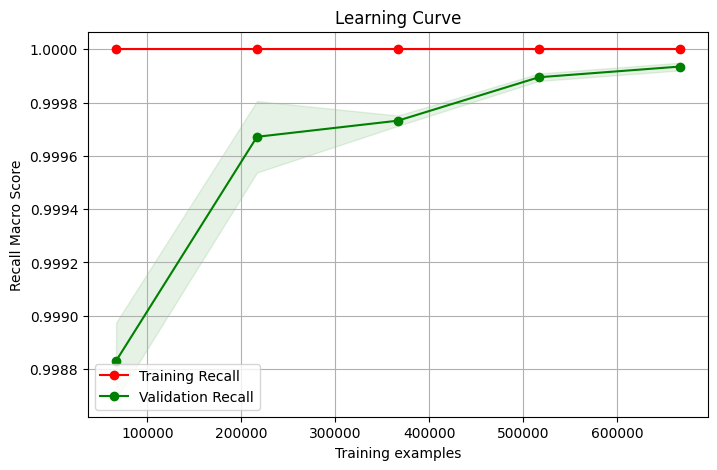

In [20]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use a fast/simple model for quick plotting if needed
dt_model = DecisionTreeClassifier(random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    dt_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring='recall_macro',
    n_jobs=-1
)

# Calculate means and stds
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Recall')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Recall')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.xlabel("Training examples")
plt.ylabel("Recall Macro Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()